In [2]:
import sys
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

sys.path.append("..")
import geoobb.obb as obb

## Load Data


In [3]:
# this data can be downloaded at
# https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
# though you'll have to filter to MN yourself
path_data = r"../data/mn_parcels.shp"

gdf = gpd.read_file(path_data)

print(f'{len(gdf):,} parcels')

42,197 parcels


## Generate OBBs


### Geometry exterior


In [9]:
%timeit gdf.geometry.map(obb.geom_to_unique_array)

1 loop, best of 3: 2.5 s per loop


In [10]:
geo_arrs = gdf.geometry.map(obb.geom_to_unique_array)
%timeit geo_arrs.map(obb.oriented_bounding_box_dimensions)

1 loop, best of 3: 3.06 s per loop


In [11]:
geo_arrs = gdf.geometry.map(obb.geom_to_unique_array)
%timeit geo_arrs.map(obb.oriented_bounding_box)

1 loop, best of 3: 3.62 s per loop


### Convex Hull


In [12]:
%timeit gdf.geometry.convex_hull.map(obb.geom_to_array)

1 loop, best of 3: 1.46 s per loop


In [13]:
convex_hull_arrs = gdf.geometry.convex_hull.map(obb.geom_to_array)
%timeit convex_hull_arrs.map(obb.oriented_bounding_box_dimensions)

1 loop, best of 3: 3.15 s per loop


In [14]:
convex_hull_arrs = gdf.geometry.convex_hull.map(obb.geom_to_array)
%timeit convex_hull_arrs.map(obb.oriented_bounding_box)

1 loop, best of 3: 3.63 s per loop


## Determine Parcel Orientions


In [16]:
obbs = geo_arrs.apply(obb.oriented_bounding_box)

angles = np.array([obb.obb_angle(o) for o in obbs])
abs_angles = np.abs(angles)

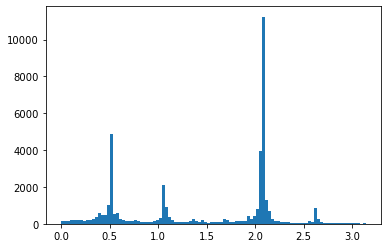

In [34]:
plt.hist(abs_angles, bins=100);

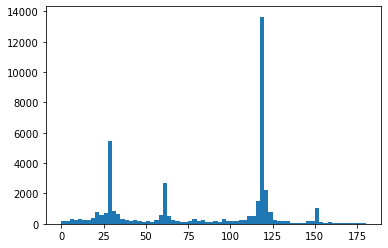

In [17]:
plt.hist(np.degrees(abs_angles), bins=np.arange(0, 182.5, 2.5));

In [19]:
a = np.degrees(abs_angles)

np.median(a), np.mean(a)

(114.93905816905996, 85.23108110874486)

In [31]:
# most frequent angle
int_angles = np.degrees(abs_angles).round(0).astype(int)
most_freq_angle = np.bincount(int_angles).argmax()

most_freq_angle

119

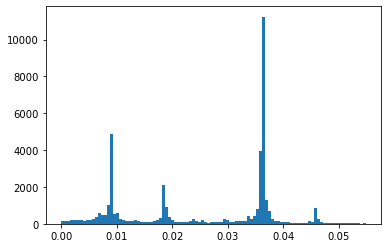

In [26]:
plt.hist(np.radians(abs_angles), bins=100);

## Most frequent angle


In [35]:
most_freq = 2.025

In [36]:
best_obb_idx = np.argmin(np.abs(angles - most_freq))

best_obb_idx

33875

### Transform Geoms


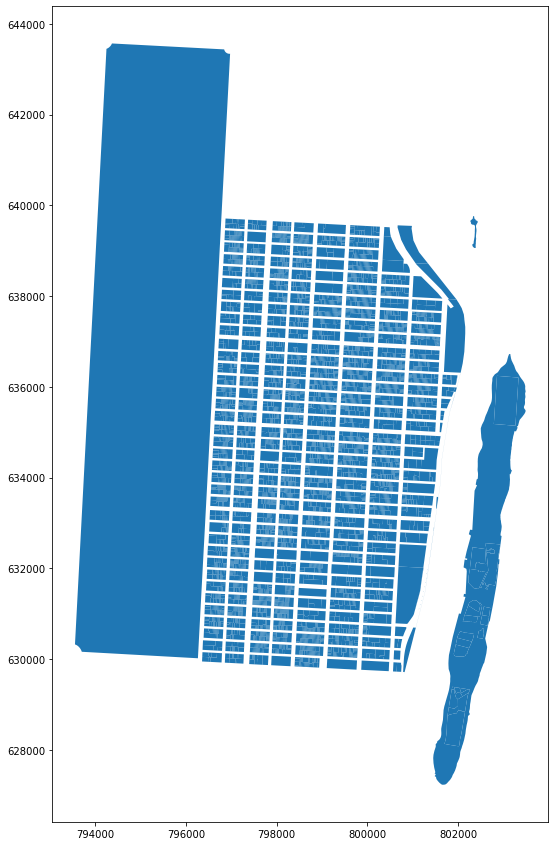

In [40]:
tvect = obb.pca_eigenvectors(geo_arrs[best_obb_idx])
af_mat = np.append(np.ravel(tvect.T), np.zeros(2))

rot_geos = gdf.copy()
rot_geos.geometry = gdf.geometry.affine_transform(af_mat)

rot_geos[rot_geos.CD.eq(108)].plot(figsize=(15, 15));

## Test Spatial Join


### Without transformation


In [43]:
xmin, ymin, xmax, ymax = gdf.sindex.bounds
rand_pts = np.random.uniform(low=(xmin, ymin), high=(xmax, ymax), size=(1000000, 2))

test_pts = gpd.GeoDataFrame(geometry=[Point(p) for p in rand_pts], crs=gdf.crs)

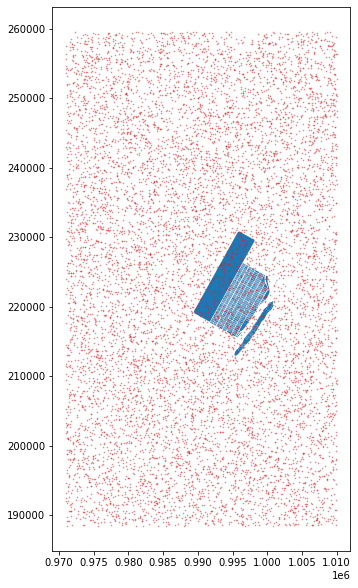

In [44]:
ax = gdf[gdf.CD.eq(108)].plot(figsize=(10, 10))
test_pts.sample(10000).plot(ax=ax, alpha=0.5, marker='.', color='tab:red', markersize=1.5);

In [45]:
%timeit gpd.sjoin(test_pts, gdf, op='within')

1 loop, best of 3: 10.6 s per loop


In [46]:
regular_join_result = gpd.sjoin(test_pts, gdf, op='within')

In [47]:
len(regular_join_result)

208040

### Rotated


In [48]:
% timeit test_pts.geometry.affine_transform(af_mat)

1 loop, best of 3: 13 s per loop


In [49]:
rot_test_pts = test_pts.geometry.affine_transform(af_mat)
rot_test_pts = gpd.GeoDataFrame(rot_test_pts, columns=['geometry'])

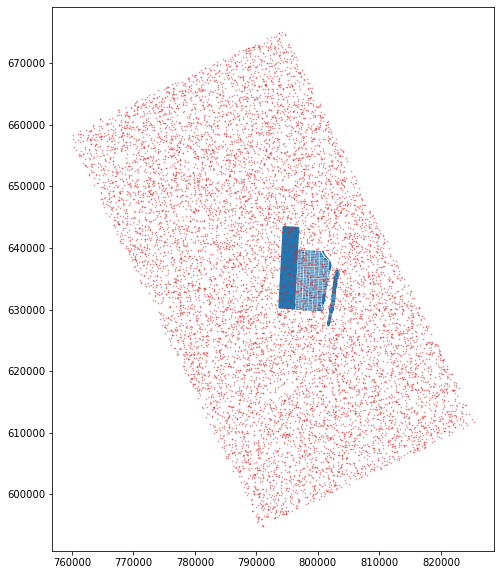

In [50]:
ax = rot_geos[rot_geos.CD.eq(108)].plot(figsize=(10, 10))
rot_test_pts.sample(10000).plot(ax=ax, alpha=0.5, marker='.', color='tab:red', markersize=1.5);

In [51]:
%timeit gpd.sjoin(rot_test_pts, rot_geos, op='within')

The slowest run took 4.41 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 7.45 s per loop


In [52]:
obb_join_result = gpd.sjoin(rot_test_pts, rot_geos, op='within')

In [53]:
len(obb_join_result)

208040

Unforunately, here again the affine transform takes longer than the join by a considerable margin.


In [55]:
test_pts.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [56]:
%timeit test_pts.to_crs(epsg=4236)

1 loop, best of 3: 25.8 s per loop
